In [107]:
from pathlib import Path
from sklearn.preprocessing import PowerTransformer
from utils import *

In [108]:
path = Path('./')
data_path = path /'data'/ 'store_sales'
df_features = pd.read_csv(data_path/ 'features.csv')
df_stores = pd.read_csv(data_path/ 'stores.csv')
df_train = pd.read_csv(data_path/ 'train.csv')

In [109]:
df = pd.merge(df_train, df_stores, on = ['Store'], how = 'left')
df_features.drop(columns = ['IsHoliday'], inplace = True)
df = pd.merge(df, df_features, on = ['Store', 'Date'], how = 'left') # df_features has some irrelevant date
df = df[[c for c in df.columns if 'MarkDown' not in c]] # too much na, not focus for now
assert(len(df[df[['Store', 'Date', 'Dept']].duplicated()]) == 0)

In [110]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by = ['Date'], inplace = True)

In [111]:
df['IsHoliday'] = df['IsHoliday'].astype(int).astype(str)

In [112]:
df.describe()

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375360,15981.258123,136727.915739,60.090059,3.361027,171.201947,7.960289
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,34875.000000,-2.060000,2.472000,126.064000,3.879000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,93638.000000,46.680000,2.933000,132.022667,6.891000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,140167.000000,62.090000,3.452000,182.318780,7.866000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,202505.000000,74.280000,3.738000,212.416993,8.572000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,219622.000000,100.140000,4.468000,227.232807,14.313000
std,12.785297,30.492054,NaN,22711.183519,60980.583328,18.447931,0.458515,39.159276,1.863296


In [113]:
df = df[df['Weekly_Sales'] >=0].copy() # just deal with positive sales for now

In [114]:
df.columns[df.isna().any(axis = 0)].tolist()

[]

In [115]:
len(df[df.isna().any(axis = 1)].index.tolist())

0

In [116]:
summ = df_summary(df)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
Index: 420285 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420285 non-null  int64         
 1   Dept          420285 non-null  int64         
 2   Date          420285 non-null  datetime64[ns]
 3   Weekly_Sales  420285 non-null  float64       
 4   IsHoliday     420285 non-null  object        
 5   Type          420285 non-null  object        
 6   Size          420285 non-null  int64         
 7   Temperature   420285 non-null  float64       
 8   Fuel_Price    420285 non-null  float64       
 9   CPI           420285 non-null  float64       
 10  Unemployment  420285 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(2)
memory usage: 38.5+ MB

Summary Statistics for Numeric Columns:
               Store           Dept   Weekly_Sales           Size  \
count  420285.000000

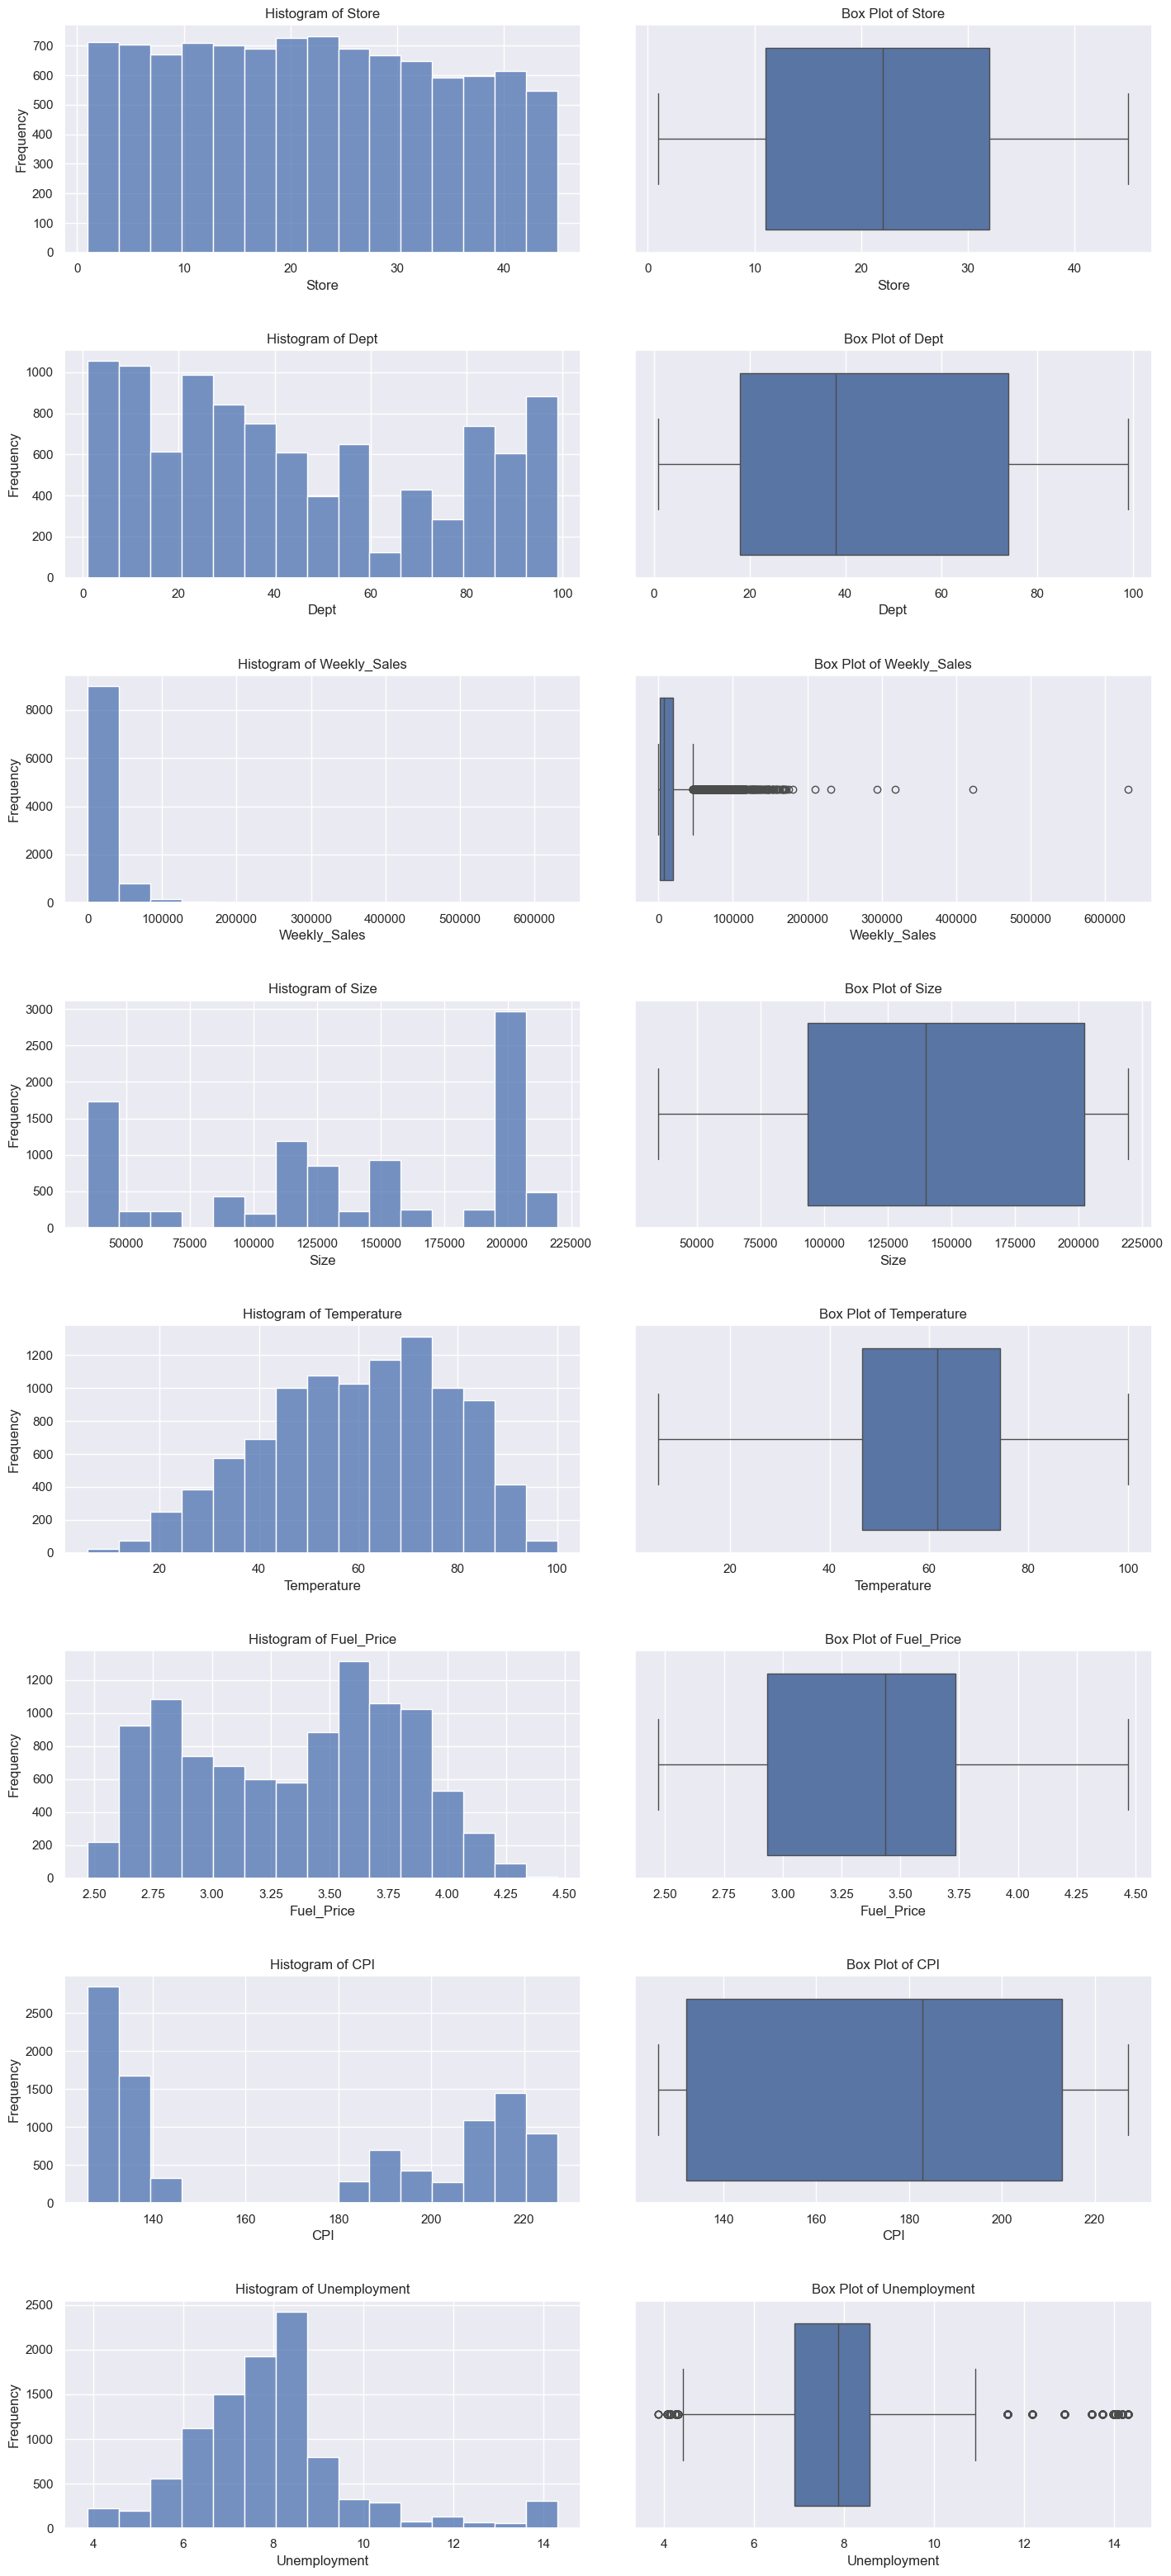

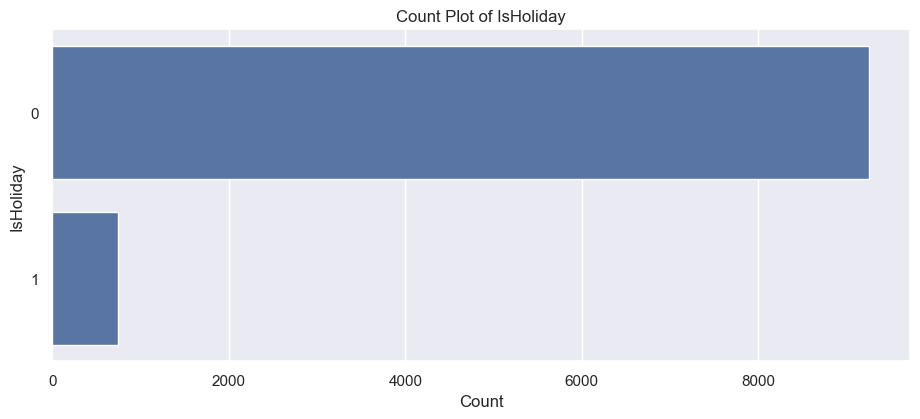

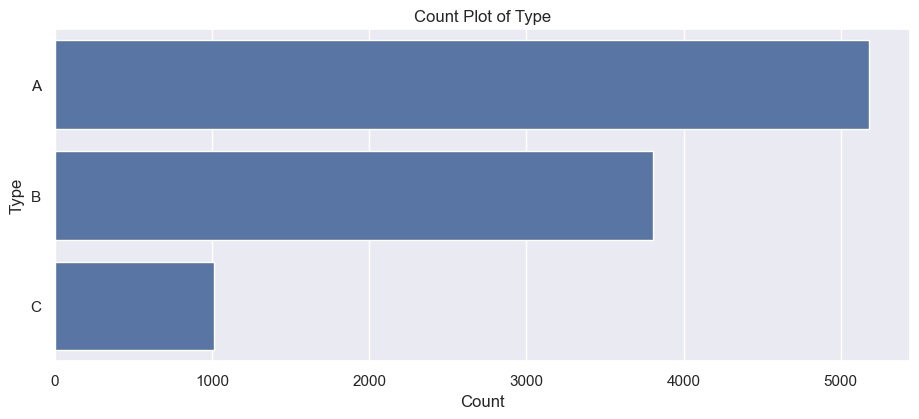

In [117]:
univariate_analysis(df, 10000)
# observe:
# Weekly_Sales, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5 are left skewed, let see if log transform will still have outlier

In [118]:
log_trans_cols = ['Weekly_Sales']
for c in log_trans_cols:
    df[f'{c}_log'] = np.log1p(df[c])

In [13]:
# import warnings
# np.warnings = warnings # just some workaround for version conflicts
# pt = PowerTransformer(method='yeo-johnson')
# df_transformed = pd.DataFrame(pt.fit_transform(df[log_trans_cols]), 
#                               columns=[col + '_transformed' for col in log_trans_cols])
# df = pd.concat([df, df_transformed], axis=1)

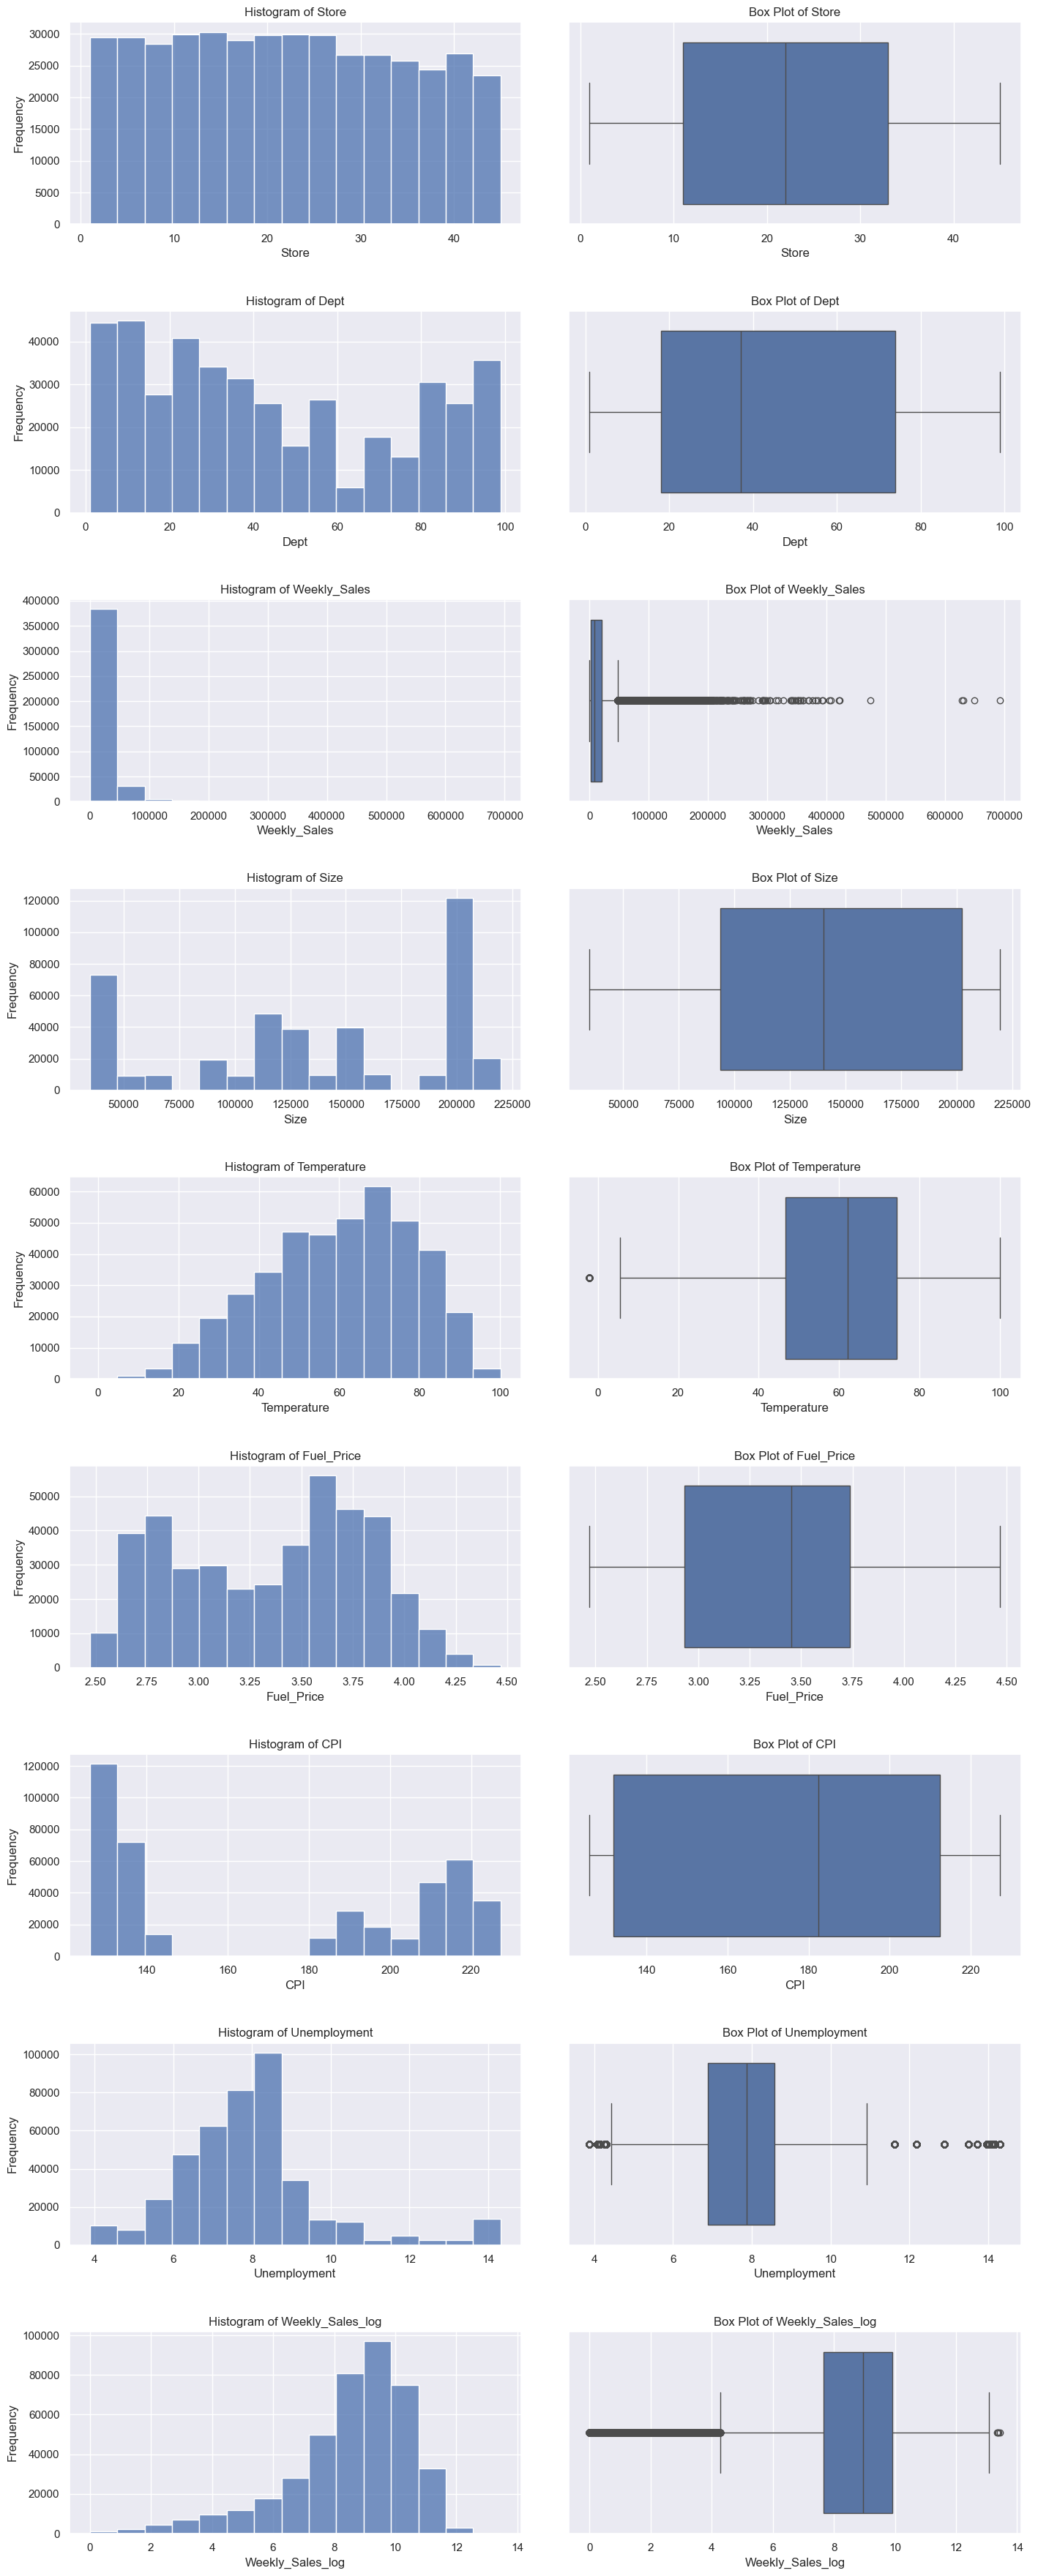

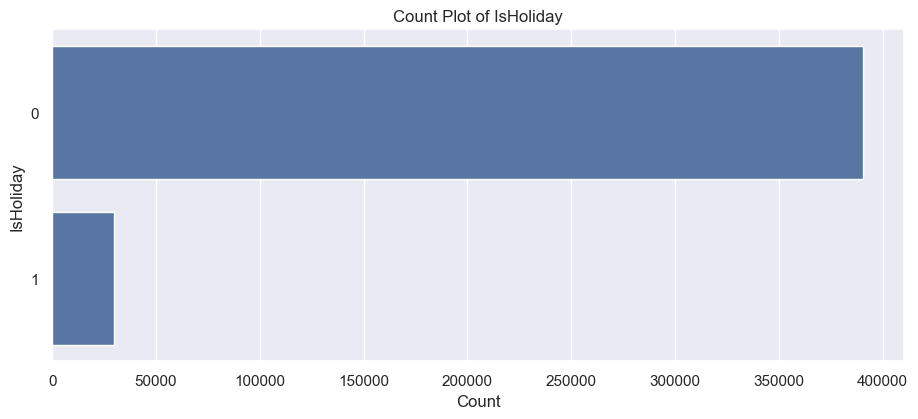

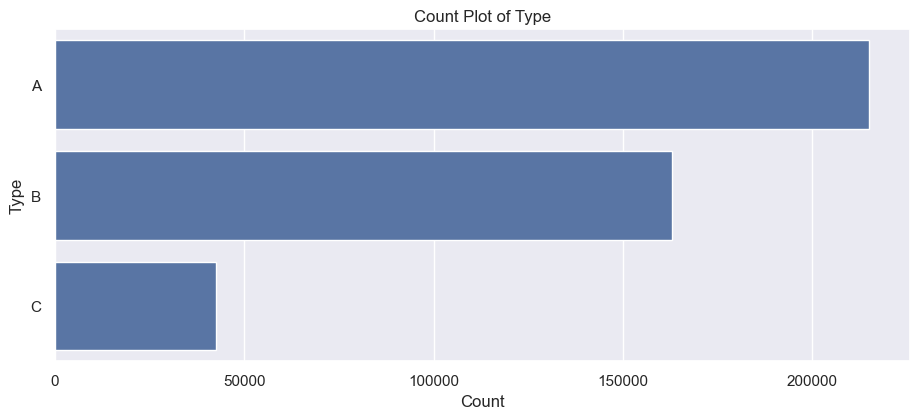

In [14]:
univariate_analysis(df)

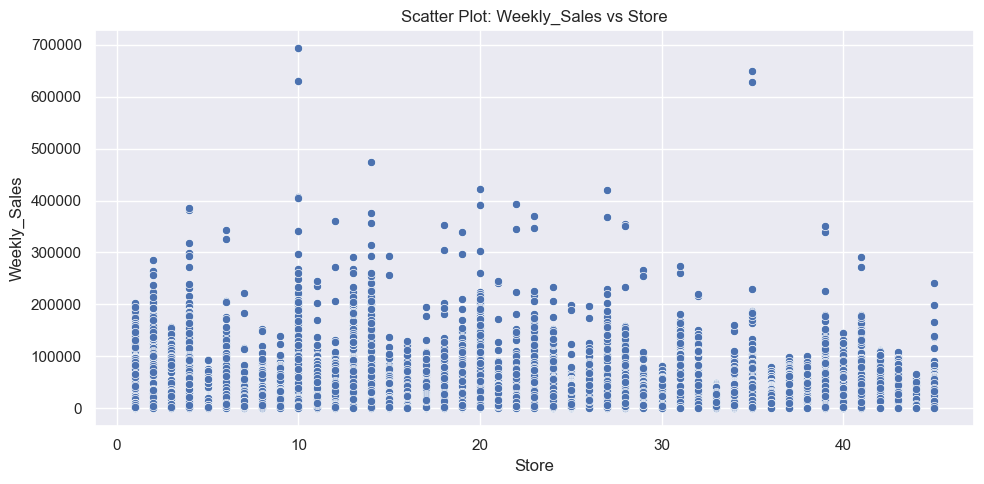

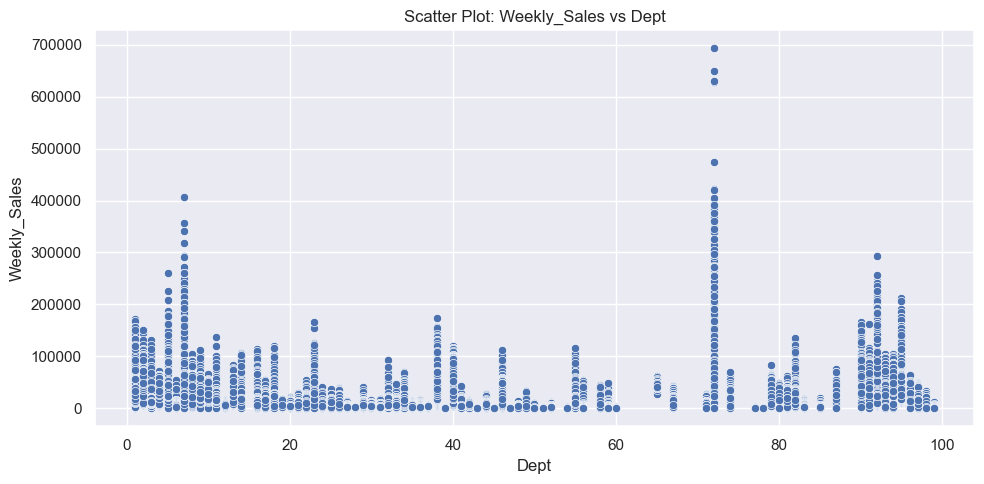

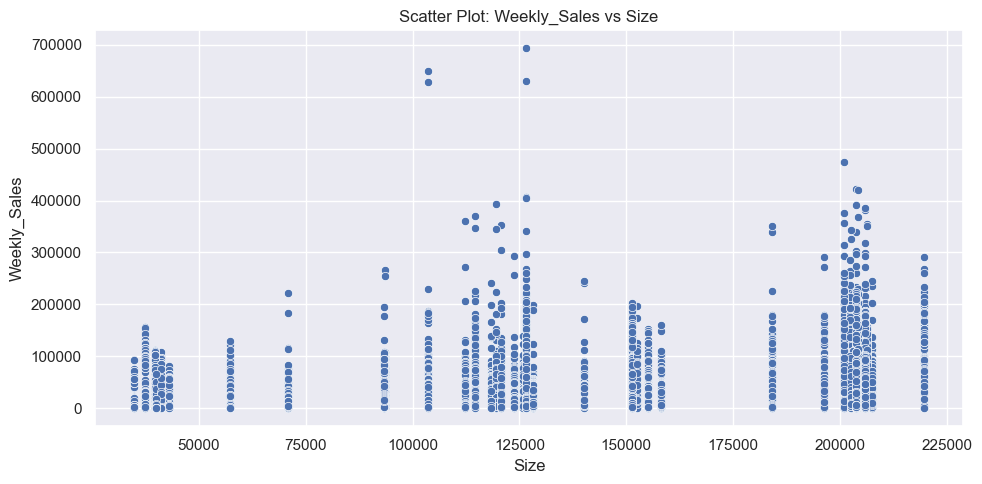

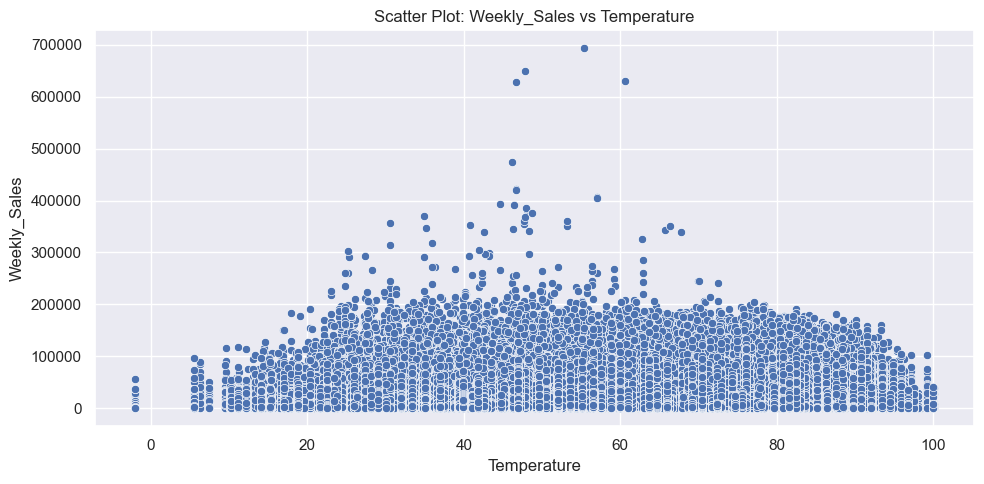

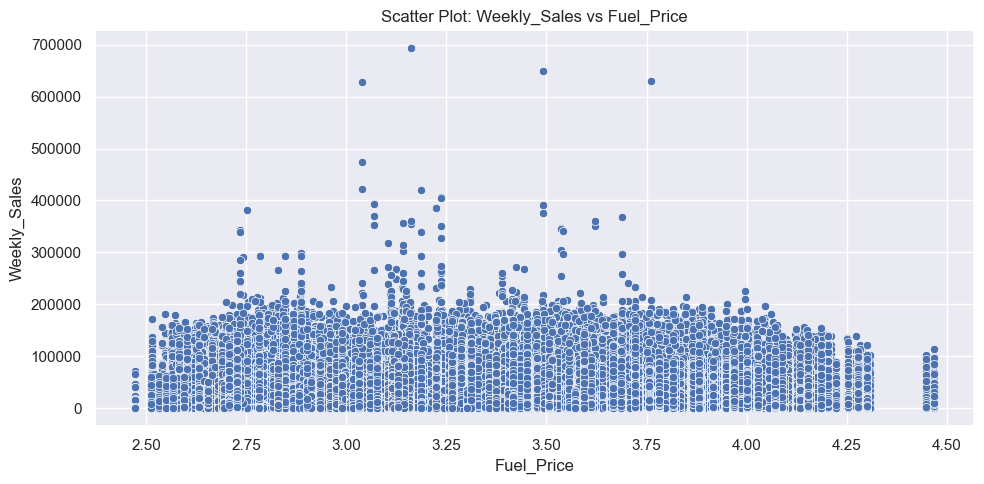

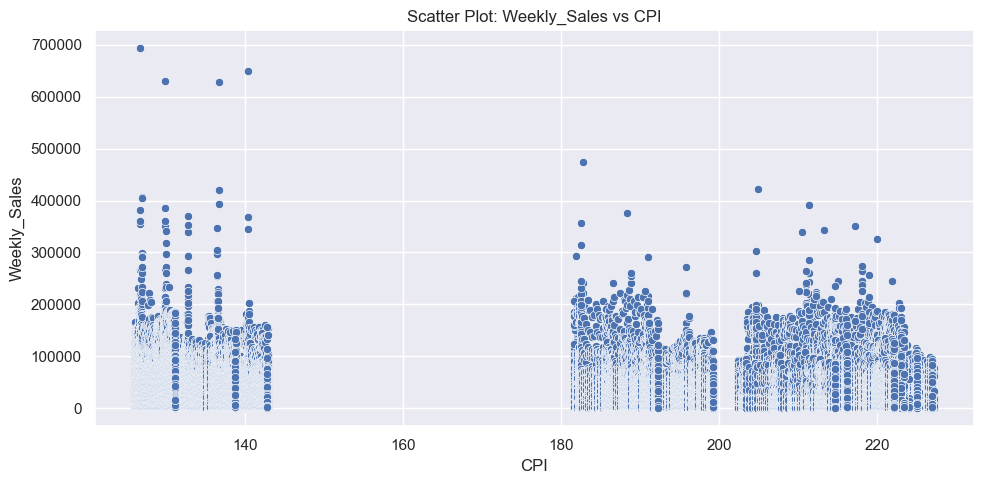

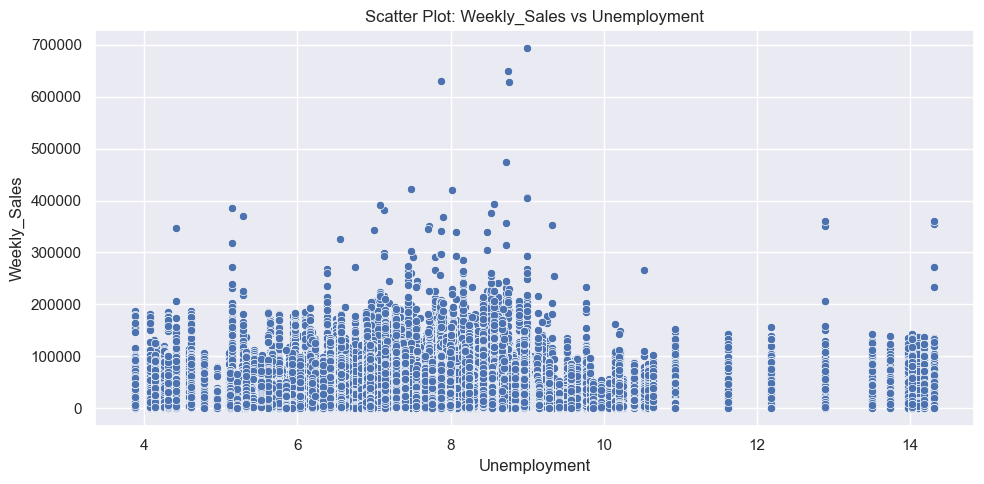

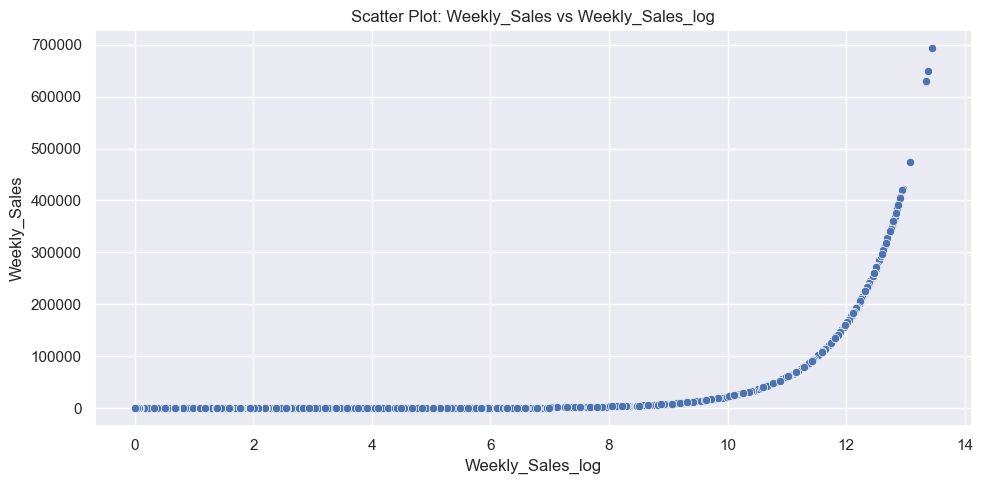

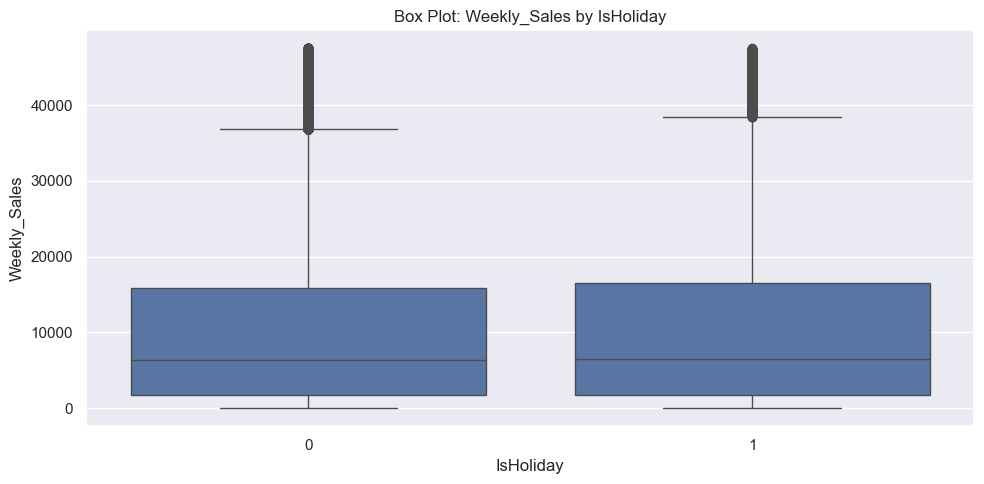

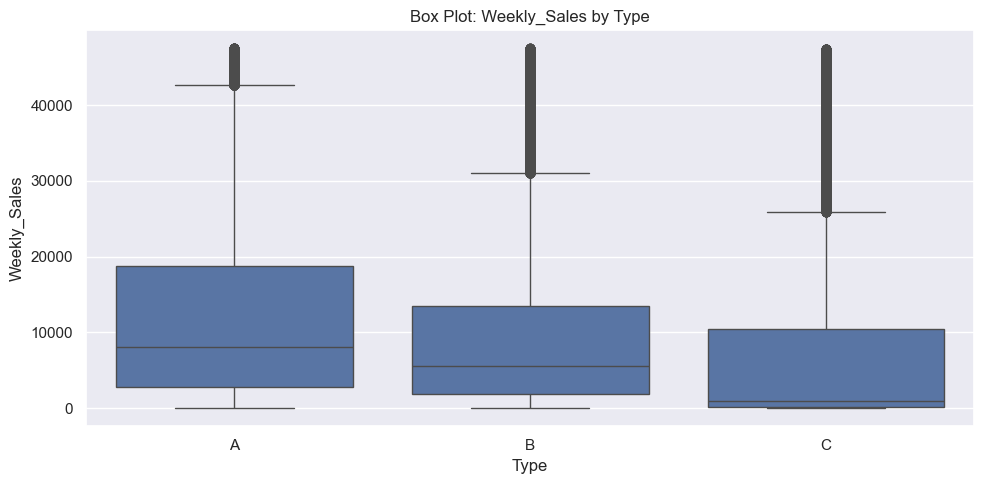

In [15]:
bivariate_analysis(df, target_column = 'Weekly_Sales')

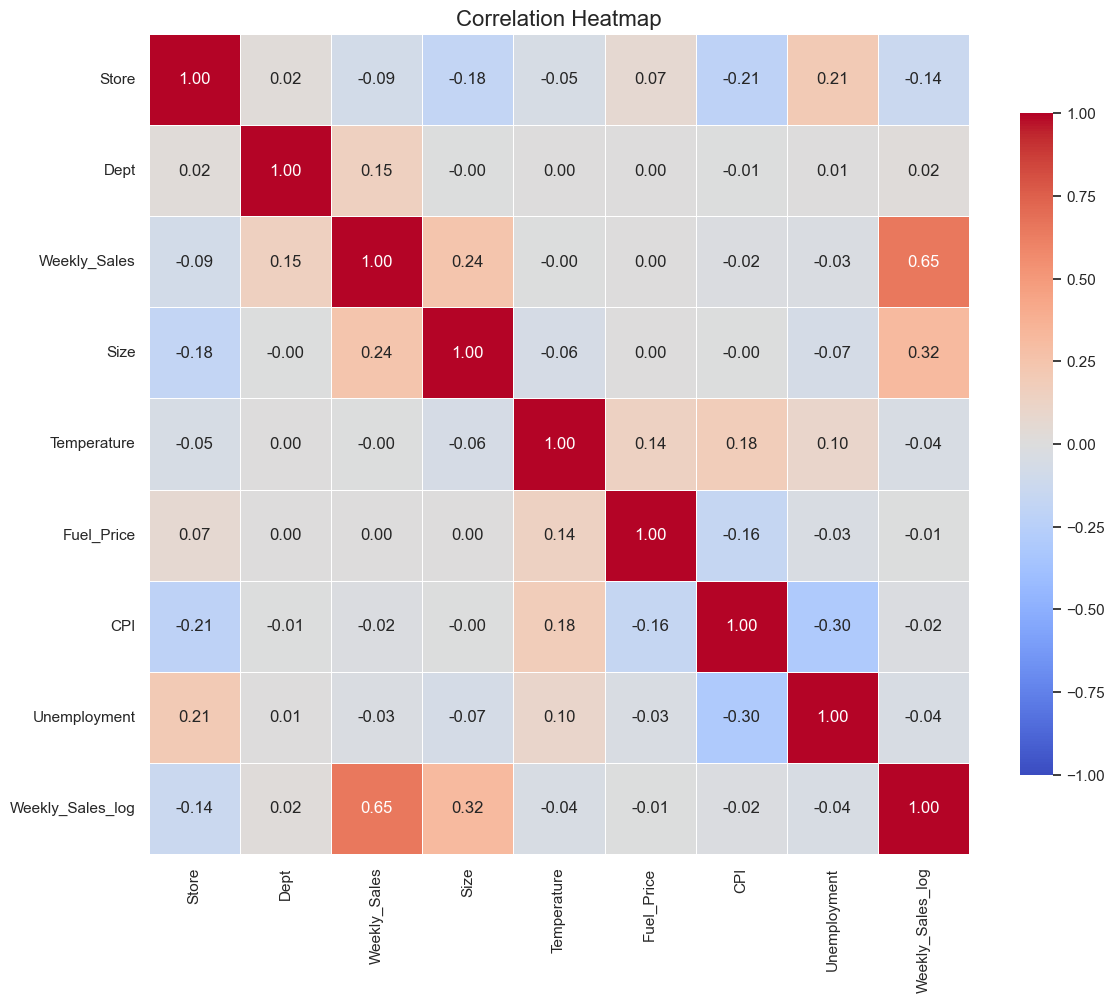

In [16]:
fast_correlation_heatmap(df, columns=None)

In [17]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_log'],
      dtype='object')

In [18]:
df = identify_outliers(df, visualize=False) # need to cut outlier, too many outlier

Number of outliers found in 'Store': 0
Number of outliers found in 'Dept': 0
Number of outliers found in 'Weekly_Sales': 35381
Number of outliers found in 'Size': 0
Number of outliers found in 'Temperature': 67
Number of outliers found in 'Fuel_Price': 0
Number of outliers found in 'CPI': 0
Number of outliers found in 'Unemployment': 32050
Number of outliers found in 'Weekly_Sales_log': 21649


In [19]:
# Perform feature selection
df = df[[c for c in df.columns if '_outlier' not in c]]
feature_results = univariate_feature_selection(df, 'Weekly_Sales_log')
print(feature_results)

             Pearson Correlation Pearson P-Value Spearman Correlation  \
Store                  -0.135282             0.0            -0.102151   
Dept                    0.022521             0.0            -0.012511   
Weekly_Sales            0.649475             0.0                  1.0   
Size                    0.318433             0.0             0.290817   
Temperature            -0.040694             0.0            -0.019905   
Fuel_Price             -0.005728        0.000204              0.00256   
CPI                    -0.017151             0.0            -0.023521   
Unemployment           -0.043448             0.0            -0.016017   

             Spearman P-Value Significant  
Store                     0.0        True  
Dept                      0.0        True  
Weekly_Sales              0.0        True  
Size                      0.0        True  
Temperature               0.0        True  
Fuel_Price           0.097053        True  
CPI                       0.0     

In [20]:
significant_cols = feature_results[feature_results['Significant'] == True].index.to_list()
significant_cols

['Store',
 'Dept',
 'Weekly_Sales',
 'Size',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment']

In [21]:
significant_cols = feature_results[feature_results['Significant'] == True].index.to_list()
## modelling
target_column = ['Weekly_Sales_log']
date_column = 'Date'
join_columns = ['Store', 'Dept']
index_columns =  [date_column] + join_columns
drop_columns = ['Weekly_Sales']
significant_cols = [c for c in significant_cols if c not in drop_columns]
is_classification = df[target_column].nunique().sum() <2

# Specify which columns to one-hot encode and which to target encode
one_hot_columns = []  # Columns for one-hot encoding (empty for default behavior)
target_encode_columns = "all"  # Columns for target encoding ('all' for default behavior)

# Step 1: Train-Test Split
X = df.drop(columns=target_column + drop_columns)
y = df[target_column + index_columns]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)

In [22]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.2, random_state=42, date_column = date_column, join_cols= join_columns)

In [23]:
X_train_encoded, X_test_encoded = encode_categorical_features(X_train, X_test, one_hot_columns, target_encode_columns, y_train[target_column])

In [24]:
feature_cols = ts_get_feature(X_train_encoded)
baseline_model = train_baseline_model(X_train_encoded[feature_cols],
                                      y_train[target_column], 
                                      is_classification = is_classification, l1_param=0)
baseline_predictions = baseline_model.predict(X_test_encoded[feature_cols])

In [25]:
pd.concat([X_train_encoded, y_train], axis = 1).corr()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales_log,Date,Store,Dept
Store,1.000000,0.025328,0.002427,-0.000461,-0.336175,-0.181371,-0.052699,0.059991,-0.211030,0.206452,-0.134418,0.002427,1.000000,0.025328
Dept,0.025328,1.000000,0.002350,0.001154,-0.015668,-0.003402,0.003978,0.002502,-0.007743,0.009550,0.023119,0.002350,0.025328,1.000000
Date,0.002427,0.002350,1.000000,0.046910,-0.003764,-0.004955,-0.094088,0.761239,0.062112,-0.170542,-0.004788,1.000000,0.002427,0.002350
IsHoliday,-0.000461,0.001154,0.046910,1.000000,0.001012,0.000672,-0.168533,-0.064291,0.002073,-0.002853,0.006246,0.046910,-0.000461,0.001154
Type,-0.336175,-0.015668,-0.003764,0.001012,1.000000,0.750786,-0.083354,-0.016576,0.043233,-0.189413,0.265766,-0.003764,-0.336175,-0.015668
Size,-0.181371,-0.003402,-0.004955,0.000672,0.750786,1.000000,-0.056188,0.008309,-0.005184,-0.080320,0.320157,-0.004955,-0.181371,-0.003402
Temperature,-0.052699,0.003978,-0.094088,-0.168533,-0.083354,-0.056188,1.000000,0.053708,0.177741,0.171983,-0.036166,-0.094088,-0.052699,0.003978
Fuel_Price,0.059991,0.002502,0.761239,-0.064291,-0.016576,0.008309,0.053708,1.000000,-0.168538,0.013443,-0.002018,0.761239,0.059991,0.002502
CPI,-0.211030,-0.007743,0.062112,0.002073,0.043233,-0.005184,0.177741,-0.168538,1.000000,-0.296772,-0.017945,0.062112,-0.211030,-0.007743
Unemployment,0.206452,0.009550,-0.170542,-0.002853,-0.189413,-0.080320,0.171983,0.013443,-0.296772,1.000000,-0.049597,-0.170542,0.206452,0.009550


In [26]:
baseline_model.named_steps

{'standardscaler': StandardScaler(), 'linearregression': LinearRegression()}

In [27]:
coefficients, intercept = baseline_coefficient(baseline_model)

LinearRegression model found.
Coefficients: [[-0.16331163  0.05304131  0.00719574  0.04007513  0.5799916  -0.02546431
  -0.00891233 -0.07474861 -0.02999285]]
Intercept: [8.53677705]


In [28]:
coef = list(intercept) + list(coefficients[0])
base_line_importance = pd.DataFrame({
    'feature_names' : ['intercept'] + feature_cols,
    'coef': coef,
    'abs_coef' : list(np.abs(coef))
})
base_line_importance = base_line_importance.sort_values(by = ['abs_coef'], ascending = False).reset_index(drop = True)

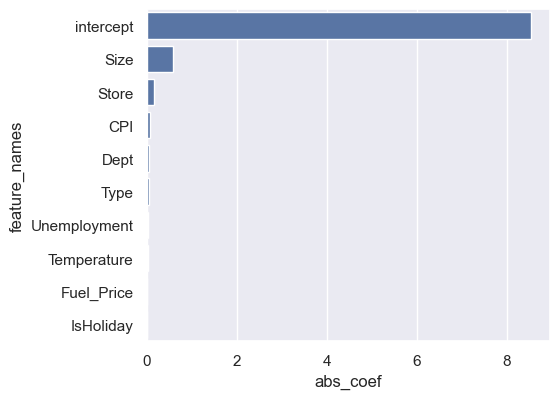

In [29]:
sns.barplot(data = base_line_importance, y = 'feature_names', x = 'abs_coef' )
plt.tight_layout(pad=3.0)

In [30]:
y_test

,Weekly_Sales_log,Date,Store,Dept
334775,8.816647,2012-04-13,22,24
334776,9.202496,2012-04-13,17,81
334777,8.524485,2012-04-13,44,80
334778,8.921013,2012-04-13,21,33
334779,9.709066,2012-04-13,40,7
...,...,...,...,...
420280,10.112125,2012-10-26,40,87
420281,8.227140,2012-10-26,19,30
420282,8.048523,2012-10-26,19,31
420283,8.655413,2012-10-26,19,33


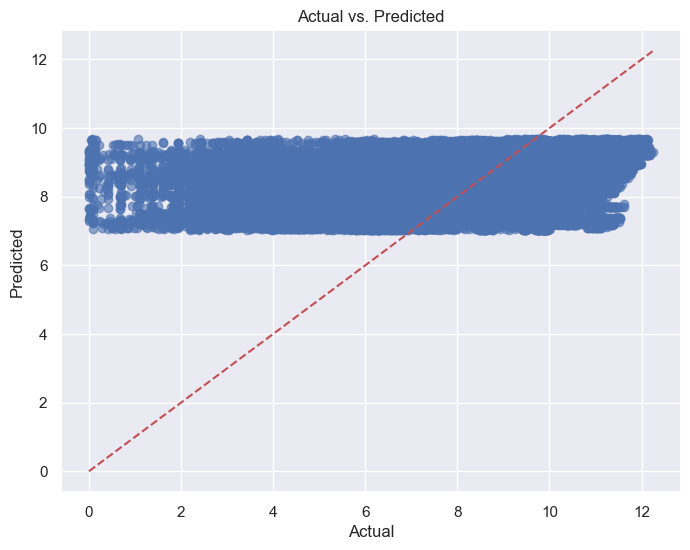

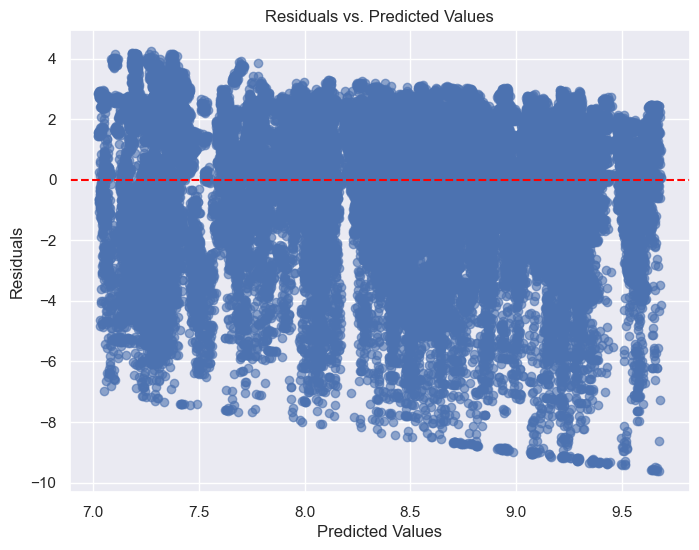

In [31]:
feature_cols = ts_get_feature(X_test_encoded)
y_pred = baseline_model.predict(X_test_encoded[feature_cols])
performance_visualize(y_test[target_column], y_pred, is_classification)

In [32]:
mae, mse, r2 = performance_report(y_test[target_column], y_pred, is_classification)

Mean Absolute Error: 1.48
Mean Squared Error: 3.84
R-squared: 0.11


In [33]:
train_metric, test_metric = evaluate_baseline_model(
    baseline_model, 
    X_train_encoded[feature_cols],
    y_train[target_column], 
    X_test_encoded[feature_cols],
    y_test[target_column], 
    is_classification = is_classification)

# Display Metrics
if is_classification:
    print(f'Baseline Model AUC on Training Set: {train_metric:.4f}')
    print(f'Baseline Model AUC on Test Set: {test_metric:.4f}')
else:
    print(f'Baseline Model MSE on Training Set: {train_metric:.4f}')
    print(f'Baseline Model MSE on Test Set: {test_metric:.4f}')

Baseline Model MSE on Training Set: 3.5931
Baseline Model MSE on Test Set: 3.8435


In [34]:
check_overfitting(train_metric, test_metric)

In [35]:
best_model, best_score, improved_features, initial_score = \
    progressive_feature_selection(
        X_train_encoded, 
        y_train, 
        is_classification,
        core_features = significant_cols,
        tscv = True,
        date_column =date_column,
        join_cols=join_columns,
        feature_cols = feature_cols,
        target_column = target_column
    )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 266391, number of used features: 7
[LightGBM] [Info] Start training from score 8.532387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 266391, number of used features: 7
[LightGBM] [Info] Start training from score 8.532387
Initial Score with Core Features on Validation Set: 0.76
Trying IsHoliday
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_c

In [36]:
best_model2, best_score2, improved_features2, initial_score2 = \
    reductive_feature_selection(
        X_train_encoded, 
        y_train, 
        is_classification,
        core_features = significant_cols,
        tscv = True,
        date_column =date_column,
        join_cols=join_columns,
        feature_cols = feature_cols,
        target_column = target_column
    )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 266391, number of used features: 9
[LightGBM] [Info] Start training from score 8.532387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 266391, number of used features: 9
[LightGBM] [Info] Start training from score 8.532387
Initial Score with Initial Features on Validation Set: 0.76
Trying to drop IsHoliday
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is se

In [37]:
# select the features for ensemble
selected_feat = list(set(significant_cols + improved_features))

In [38]:
selected_feat

['Size', 'Store', 'CPI', 'Fuel_Price', 'Unemployment', 'Temperature', 'Dept']

In [39]:
X_train_encoded.index.unique()

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       334765, 334766, 334767, 334768, 334769, 334770, 334771, 334772, 334773,
       334774],
      dtype='int64', length=334775)

In [40]:
len(X_train_encoded.index.unique())

334775

In [41]:
len(y_train.index.unique())

334775

In [42]:
y_train.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       334765, 334766, 334767, 334768, 334769, 334770, 334771, 334772, 334773,
       334774],
      dtype='int64', length=334775)

In [43]:
y_train

,Weekly_Sales_log,Date,Store,Dept
0,10.123647,2010-02-05,1,1
1,9.652014,2010-02-05,29,5
2,8.071287,2010-02-05,29,6
3,9.289249,2010-02-05,29,7
4,9.906316,2010-02-05,29,8
...,...,...,...,...
334770,9.318855,2012-04-06,34,14
334771,9.199156,2012-04-06,8,80
334772,7.811884,2012-04-06,27,52
334773,7.474954,2012-04-06,5,24


In [44]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [45]:
len(np.unique(X_train_encoded.index))

334775

In [46]:
len(np.unique(y_train.index))

334775

In [47]:
set(y_train[target_column[0]].index) - set(X_train_encoded.index)

set()

In [48]:
set(X_train_encoded.index)  - set(y_train[target_column[0]].index)

set()

In [49]:
# Choose which set of hyperparameters to use
hyperparameter_set = 'quick'  # Change to 'quick' for faster optimization
models = models_classification if is_classification else models_regression
best_models = optimize_all_models(models,
                                 hyperparameter_set,
                                  X_train_encoded[selected_feat],
                                  y_train[target_column[0]],
                                  is_classification,
                                  tscv = True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed

Best CatBoost Parameters (quick): {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently in

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 334775, number of used features: 7
[LightGBM] [Info] Start training from score 8.536777
Best LightGBM Parameters (quick): {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 63}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

Best XGBoost Parameters (quick): {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [50]:
# Generate ensemble predictions
train_ensemble_preds = ensemble_predict(best_models, X_train_encoded[selected_feat],
                                        is_classification = is_classification)
test_ensemble_preds = ensemble_predict(best_models, X_test_encoded[selected_feat],
                                       is_classification = is_classification)

In [51]:
# Evaluate all models including ensemble
evaluation_results = evaluate_multi_models(best_models, y_train[target_column[0]],
                                           y_test[target_column[0]],
                                           train_ensemble_preds, test_ensemble_preds,
                                           X_train_encoded[selected_feat], X_test_encoded[selected_feat],
                                           is_classification = is_classification)

# Display evaluation results
print("Evaluation Results:")
for model_name, metrics in evaluation_results.items():
    print(f"{model_name}: Train Metric = {metrics['Train Metric']}, Test Metric = {metrics['Test Metric']}")

Evaluation Results:
Ensemble: Train Metric = 0.5322977569786195, Test Metric = 0.6413837800539592
CatBoost: Train Metric = 1.0645652084762305, Test Metric = 1.1512832596384979
LightGBM: Train Metric = 0.3347479141696265, Test Metric = 0.4643758423428774
XGBoost: Train Metric = 0.48365951429688536, Test Metric = 0.5865877750284308


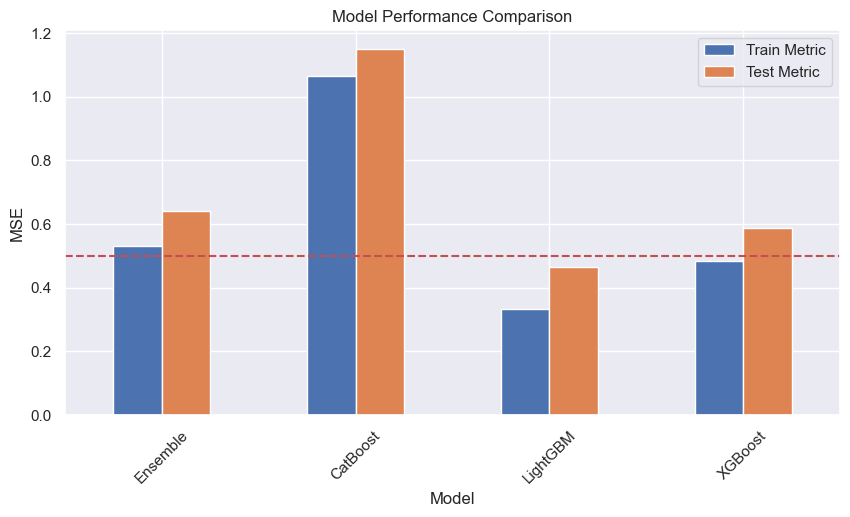

,Model,Train Metric,Test Metric
0,Ensemble,0.532298,0.641384
1,CatBoost,1.064565,1.151283
2,LightGBM,0.334748,0.464376
3,XGBoost,0.483660,0.586588


In [52]:
# Call the plotting function for classification and regression
plot_model_performance(evaluation_results, is_classification)

In [53]:
# res_df = X_test.copy()
# res_df['EverDelinquent'] = y_test
# res_df['y_pred'] = test_ensemble_preds

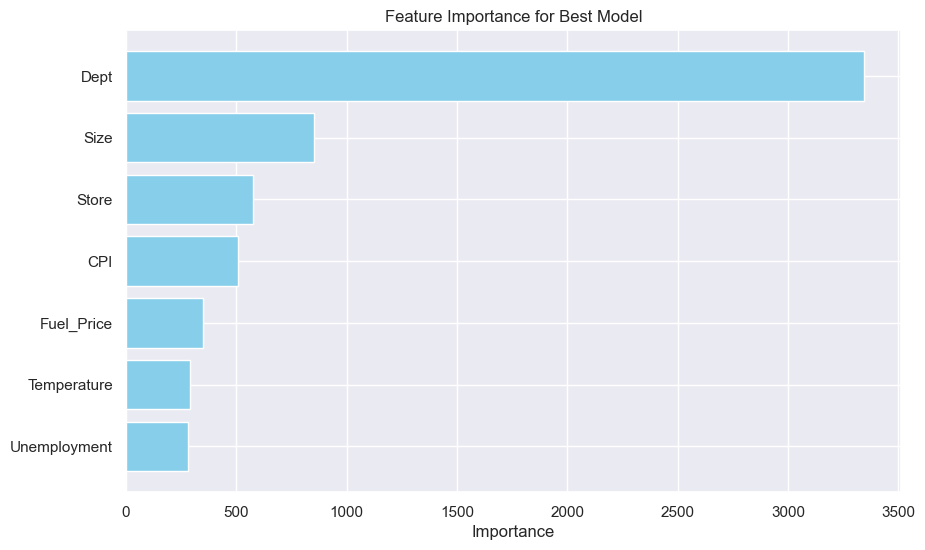

,Feature,Importance
6,Dept,3345
0,Size,851
1,Store,577
2,CPI,508
3,Fuel_Price,347
5,Temperature,291
4,Unemployment,281


In [54]:
lgb_feature_importance(best_models['LightGBM'], plot = True)

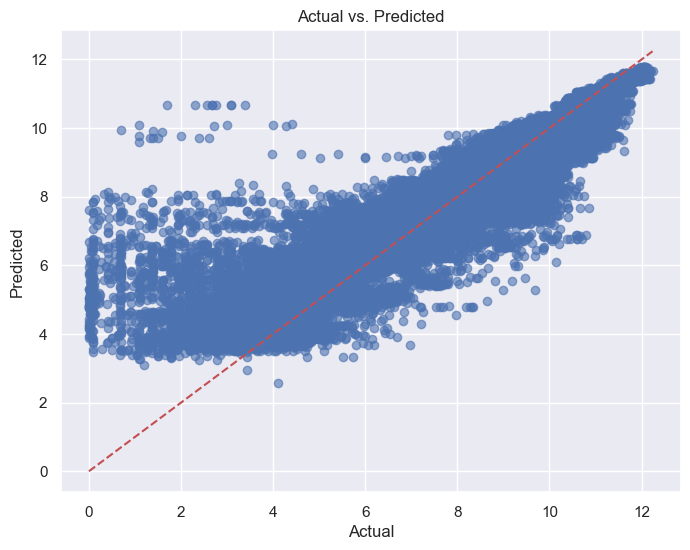

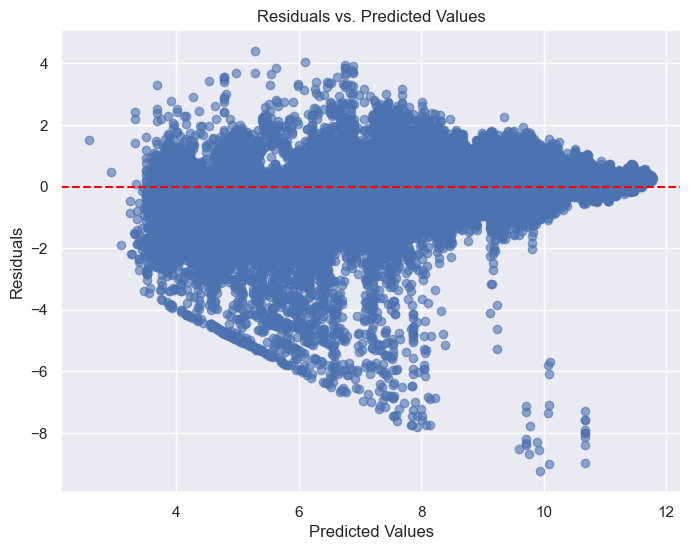

In [55]:
performance_visualize(y_test[target_column[0]], test_ensemble_preds, is_classification)

In [ ]:
t = df.copy()

In [197]:
df = t.copy()

In [198]:
## feature engineering
# rolling feat
rolling_feats = ['Weekly_Sales_log']
df.sort_values(by = index_columns).reset_index(drop = True)
for roll_win in [3,5,10]:
    df[[f'rolling{roll_win}_{c}' for c in rolling_feats]] = (
        df.groupby(join_columns)[rolling_feats].rolling(window = 3).mean()
    ).reset_index(level=0, drop=True).reset_index(level=0, drop=True)
rolling_cols = [c for c in df.columns if 'rolling' in c]

In [199]:
# Percentage change of Weekly Sales
df['Weekly_Sales_log_pctchg'] = df.groupby(join_columns)['Weekly_Sales_log'].pct_change()
df['Weekly_Sales_log_pctchg'] = df['Weekly_Sales_log_pctchg'].apply(lambda x: min(x, 10))

In [200]:
feature_cols = []

In [201]:
# lag feat
lag_feats = ['Weekly_Sales_log', 'Fuel_Price', 'Temperature'] + rolling_cols + ['Weekly_Sales_log_pctchg']
df.sort_values(by = index_columns)
for lag in range(1,4):
    df[[f'lag{lag}_{c}' for c in lag_feats]] = df.groupby(join_columns)[lag_feats].shift(lag)
lag_cols = [c for c in df.columns if 'lag' in c]
feature_cols += lag_cols

In [202]:
# monthly, weekday agg
agg_dt = {
    'Weekly_Sales_log' : ['mean', 'std', 'max', 'min']
}
agg_feats = ['Weekly_Sales_log']
df['month'] = df['Date'].dt.to_period('M')
df['weekday'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter

df_month = df.groupby(['month'])[agg_feats].agg(agg_dt).reset_index()
feature_cols += ['weekday', 'quarter']

In [203]:
# past month
df_month['month'] = df_month['month'].shift(-1)

In [204]:
df_month.columns = ['monthly_'.join(col).strip() for col in df_month.columns.values]

In [205]:
df_month.columns = ['month'] + list(df_month.columns[1:])
feature_cols += list(df_month.columns[1:])

In [206]:
df = pd.merge(df, df_month, on = 'month', how = 'left')

In [207]:
df2 = df[feature_cols + index_columns].copy()
df2[target_column] = df[target_column]
df2['Date'] = df['Date']

In [208]:
df2

,lag1_Weekly_Sales_log,lag1_Fuel_Price,lag1_Temperature,lag1_rolling3_Weekly_Sales_log,lag1_rolling5_Weekly_Sales_log,lag1_rolling10_Weekly_Sales_log,lag1_Weekly_Sales_log_pctchg,lag2_Weekly_Sales_log,lag2_Fuel_Price,lag2_Temperature,...,weekday,quarter,Weekly_Sales_logmonthly_mean,Weekly_Sales_logmonthly_std,Weekly_Sales_logmonthly_max,Weekly_Sales_logmonthly_min,Date,Store,Dept,Weekly_Sales_log
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,NaN,NaN,NaN,NaN,2010-02-05,1,1,10.123647
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,NaN,NaN,NaN,NaN,2010-02-05,29,5,9.652014
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,NaN,NaN,NaN,NaN,2010-02-05,29,6,8.071287
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,NaN,NaN,NaN,NaN,2010-02-05,29,7,9.289249
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,NaN,NaN,NaN,NaN,2010-02-05,29,8,9.906316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420280,9.991857,4.000,46.33,10.180310,10.180310,10.180310,-0.019310,10.188603,4.029,47.35,...,4,4,8.454385,2.0451,12.157831,0.00995,2012-10-26,40,87,10.112125
420281,8.170587,4.153,53.44,8.106851,8.106851,8.106851,0.013793,8.059422,4.186,48.29,...,4,4,8.454385,2.0451,12.157831,0.00995,2012-10-26,19,30,8.227140
420282,7.834654,4.153,53.44,7.913833,7.913833,7.913833,-0.030090,8.077711,4.186,48.29,...,4,4,8.454385,2.0451,12.157831,0.00995,2012-10-26,19,31,8.048523
420283,8.706212,4.153,53.44,8.704569,8.704569,8.704569,0.002270,8.686495,4.186,48.29,...,4,4,8.454385,2.0451,12.157831,0.00995,2012-10-26,19,33,8.655413


In [209]:
# Step 1: Train-Test Split
X = df2.drop(columns=target_column)
y = df2[target_column + index_columns]
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.2, random_state=42, date_column=date_column,
                                                       join_cols=join_columns)
X_train_encoded, X_test_encoded = encode_categorical_features(X_train, X_test, one_hot_columns, target_encode_columns, y_train[target_column])

In [210]:
feature_cols

['lag1_Weekly_Sales_log',
 'lag1_Fuel_Price',
 'lag1_Temperature',
 'lag1_rolling3_Weekly_Sales_log',
 'lag1_rolling5_Weekly_Sales_log',
 'lag1_rolling10_Weekly_Sales_log',
 'lag1_Weekly_Sales_log_pctchg',
 'lag2_Weekly_Sales_log',
 'lag2_Fuel_Price',
 'lag2_Temperature',
 'lag2_rolling3_Weekly_Sales_log',
 'lag2_rolling5_Weekly_Sales_log',
 'lag2_rolling10_Weekly_Sales_log',
 'lag2_Weekly_Sales_log_pctchg',
 'lag3_Weekly_Sales_log',
 'lag3_Fuel_Price',
 'lag3_Temperature',
 'lag3_rolling3_Weekly_Sales_log',
 'lag3_rolling5_Weekly_Sales_log',
 'lag3_rolling10_Weekly_Sales_log',
 'lag3_Weekly_Sales_log_pctchg',
 'weekday',
 'quarter',
 'Weekly_Sales_logmonthly_mean',
 'Weekly_Sales_logmonthly_std',
 'Weekly_Sales_logmonthly_max',
 'Weekly_Sales_logmonthly_min']

In [211]:
hyperparameter_set = 'quick'  # Change to 'quick' for faster optimization
models = models_classification if is_classification else models_regression
best_models = optimize_all_models(models,
                                 hyperparameter_set,
                                  X_train_encoded[feature_cols],
                                  y_train[target_column[0]],
                                  is_classification,
                                  tscv = True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Best CatBoost Parameters (quick): {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 4/4] START learning_rate=0.1, max_depth=6, n_estimators=100............
[CV 1/3; 4/4] END learning_rate=0.1, max_depth=6, n_estimators=100;, score=nan total time=   0.4s
[CV 1/3; 4/4] START depth=6, iterations=100, learning_rate=0.1..................
[CV 1/3; 4/4] END depth=6, iterations=100, learning_rate=0.1;, score=-0.201 total time=   4.0s
[CV 2/3; 1/4] START learning_rate=0.1, n_estimators=50, num_leaves=31...........
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the train set: 167389, number of used features: 26
[LightGBM] [Info] Start training from score 8.554578
[CV 2/3; 1/4] END learning_rate=0.1, n_estimators=50, num_leaves=31;, sco

/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:08:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

[CV 2/3; 2/4] START depth=4, iterations=100, learning_rate=0.1..................
[CV 2/3; 2/4] END depth=4, iterations=100, learning_rate=0.1;, score=-0.151 total time=   5.8s
[CV 1/3; 3/4] START learning_rate=0.1, n_estimators=100, num_leaves=31..........
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4462
[LightGBM] [Info] Number of data points in the train set: 83696, number of used features: 23
[LightGBM] [Info] Start training from score 8.548344
[CV 1/3; 3/4] END learning_rate=0.1, n_estimators=100, num_leaves=31;, score=-0.210 total time=   9.1s
[CV 3/3; 1/4] START depth=4, iterations=50, learning_rate=0.1...................
[CV 3/3; 1/4] END depth=4, iterations=50, learning_rate=0.1;, score=-0.178 total time=   3.6s
[CV 2/3; 1/4] START learning_rate=0.1, n_estimators=50, num

/Users/scottau/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:08:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters (quick): {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


In [212]:
# Generate ensemble predictions
train_ensemble_preds = ensemble_predict(best_models, X_train_encoded[feature_cols],
                                        is_classification=is_classification)
test_ensemble_preds = ensemble_predict(best_models, X_test_encoded[feature_cols],
                                       is_classification=is_classification)
# Evaluate all models including ensemble
evaluation_results = evaluate_multi_models(best_models, y_train[target_column[0]],
                                           y_test[target_column[0]],
                                           train_ensemble_preds, test_ensemble_preds,
                                           X_train_encoded[feature_cols], X_test_encoded[feature_cols],
                                           is_classification=is_classification)

# Display evaluation results
print("Evaluation Results:")
for model_name, metrics in evaluation_results.items():
    print(f"{model_name}: Train Metric = {metrics['Train Metric']}, Test Metric = {metrics['Test Metric']}")

Evaluation Results:
Ensemble: Train Metric = 0.1850285271981788, Test Metric = 0.14330232355114722
CatBoost: Train Metric = 0.19440617519178321, Test Metric = 0.14647527153662993
LightGBM: Train Metric = 0.18592905815387833, Test Metric = 0.1445396643147883
XGBoost: Train Metric = 0.18123572407069446, Test Metric = 0.1445483894172113


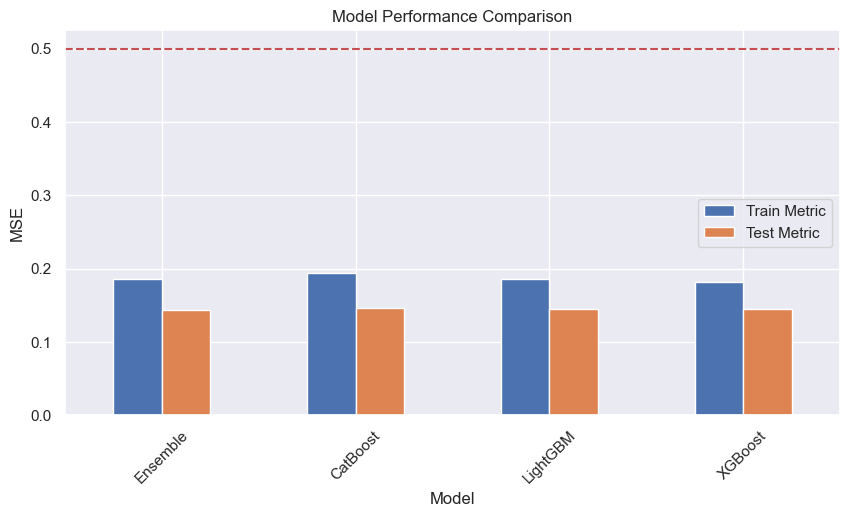

,Model,Train Metric,Test Metric
0,Ensemble,0.185029,0.143302
1,CatBoost,0.194406,0.146475
2,LightGBM,0.185929,0.144540
3,XGBoost,0.181236,0.144548


In [213]:
plot_model_performance(evaluation_results, is_classification)

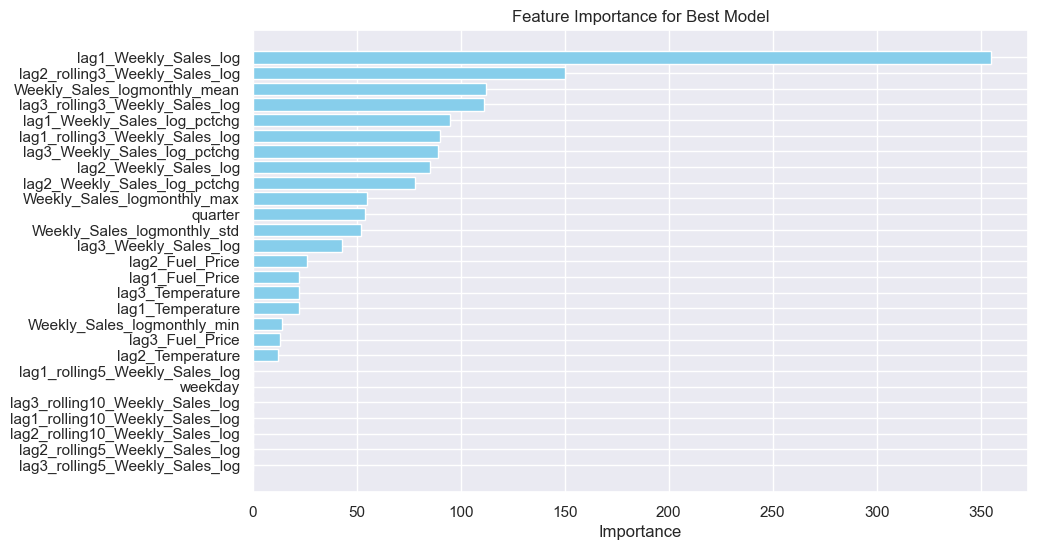

,Feature,Importance
0,lag1_Weekly_Sales_log,355
10,lag2_rolling3_Weekly_Sales_log,150
23,Weekly_Sales_logmonthly_mean,112
17,lag3_rolling3_Weekly_Sales_log,111
6,lag1_Weekly_Sales_log_pctchg,95
3,lag1_rolling3_Weekly_Sales_log,90
20,lag3_Weekly_Sales_log_pctchg,89
7,lag2_Weekly_Sales_log,85
13,lag2_Weekly_Sales_log_pctchg,78
25,Weekly_Sales_logmonthly_max,55


In [214]:
lgb_feature_importance(best_models['LightGBM'], plot = True)

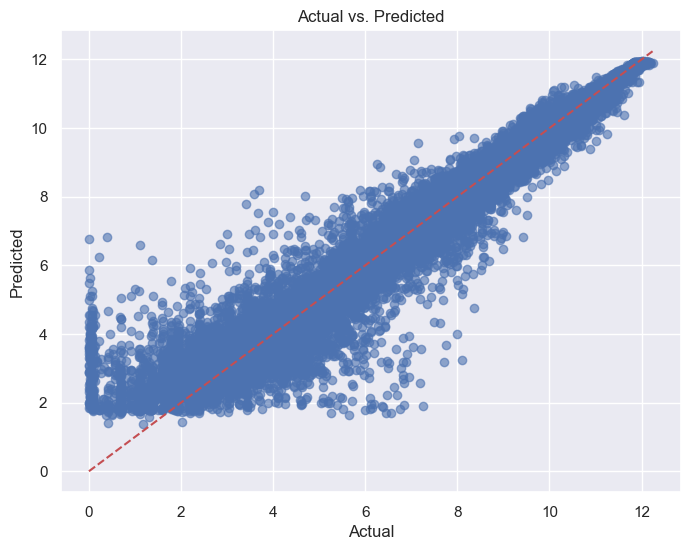

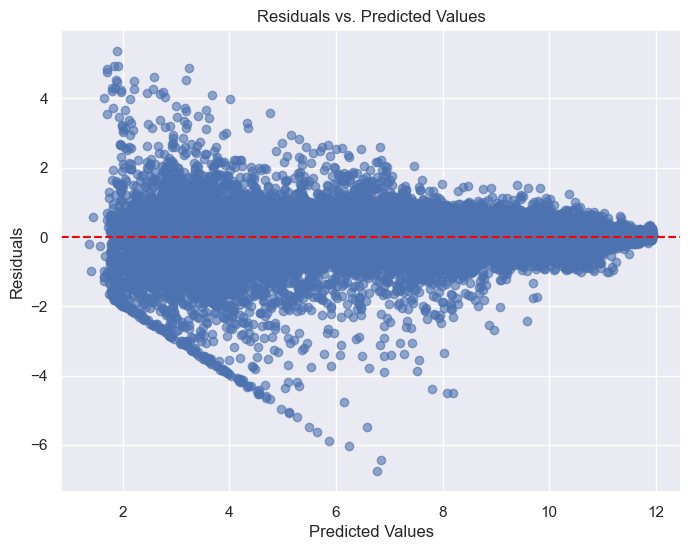

In [215]:
performance_visualize(y_test[target_column[0]], test_ensemble_preds, is_classification)

In [ ]:
df_month['m'] = df_month['month'].apply(lambda x: str(x)[5:])
df_month[[f'month_lag_{c}' for c in agg_feats]] = \
    df_month.groupby(['m'] + join_columns)[agg_feats].shift(1)

In [75]:
df['m'] = df['month'].apply(lambda x: str(x)[5:])

In [76]:
df[[f'month_lag_{c}' for c in agg_feats]] = df.groupby(['m'] + join_columns)[agg_feats].shift(1)

In [77]:
df_date = df.groupby(['Date'])[target_column].mean()

In [78]:
agg_dt = {
    'Weekly_Sales_log' : ['mean', 'std', 'max', 'min']
}

In [79]:
df_date

,Weekly_Sales_log
Date,
2010-02-05,8.538771
2010-02-12,8.595003
2010-02-19,8.559801
2010-02-26,8.445873
2010-03-05,8.518110
...,...
2012-09-28,8.470169
2012-10-05,8.546397
2012-10-12,8.499011


In [187]:
rolling_results = df.groupby(join_columns).rolling(window=4).agg(agg_dt).reset_index(level = 0, drop = True).reset_index(level = 0, drop = True)

In [189]:
rolling_results
rolling_results.columns = ['_'.join(col).strip() for col in rolling_results.columns.values]

In [190]:
rolling_results

,Weekly_Sales_log_mean,Weekly_Sales_log_std,Weekly_Sales_log_max,Weekly_Sales_log_min,Fuel_Price_mean,Fuel_Price_std,Fuel_Price_max,Fuel_Price_min,Temperature_mean,Temperature_std,Temperature_max,Temperature_min
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.342490,0.412286,10.737277,9.873262,2.54875,0.025158,2.572,2.514,41.8450,3.554429,46.63,38.51
4,10.309325,0.440151,10.737277,9.873262,2.56200,0.046440,2.625,2.514,42.8925,4.280408,46.63,38.51
...,...,...,...,...,...,...,...,...,...,...,...,...
421565,6.164615,0.225502,6.408463,5.867714,3.97350,0.055585,4.038,3.911,68.4425,5.014661,75.70,64.88
421566,6.308759,0.140843,6.444290,6.149109,3.99200,0.037085,4.038,3.948,65.7400,1.434736,67.87,64.88
421567,6.448626,0.367797,6.967928,6.149109,4.00500,0.022935,4.038,3.985,62.3900,5.283982,65.32,54.47
421568,6.570010,0.311865,6.967928,6.233175,3.98775,0.014080,4.000,3.969,60.1775,5.496735,64.89,54.47


In [ ]:
# Percentage change of Weekly Sales
df['Weekly_Sales_Percent_Change'] = df.groupby(level='store')['Weekly_Sales_log'].pct_change()

In [ ]:
# long short diff of rolling average

In [ ]:
# time series decomposion

In [ ]:
# cross sectional agg ie groupby date, std/mean

In [ ]:
# check list and upload to github

In [ ]:
#df['Momentum'] = df['Close'].pct_change(periods=5)

In [ ]:
# Function to create the time since the event
# def time_since_event(series):
#     time_passed = []
#     count = 0
#     for event in series:
#         if event == 1:
#             count = 1  # Reset to 1 when an event occurs
#         else:
#             count += 1 if count > 0 else 0  # Increment only if count > 0
#         time_passed.append(count)
#     return time_passed

In [ ]:
# Function to create features
def create_features(group):
    group = group.copy()
    group['Cumulative_Events'] = group['Event'].cumsum()
    group['Moving_Average'] = group['Event'].rolling(window=3, min_periods=1).mean()
    group['Lagged_Event'] = group['Event'].shift(1)
    group['Rolling_Mean'] = group['Event'].rolling(window=5, min_periods=1).mean()
    group['Rolling_Std'] = group['Event'].rolling(window=5, min_periods=1).std()

    # Time Since Last Event
    time_passed = []
    count = 0
    for event in group['Event']:
        if event == 1:
            count = 1  # Reset to 1 when an event occurs
        else:
            count += 1 if count > 0 else 0  # Increment only if count > 0
        time_passed.append(count)
    group['Time_Since_Last_Event'] = time_passed

    return group

# Apply the function using groupby
features_df = df.groupby('Group').apply(create_features)

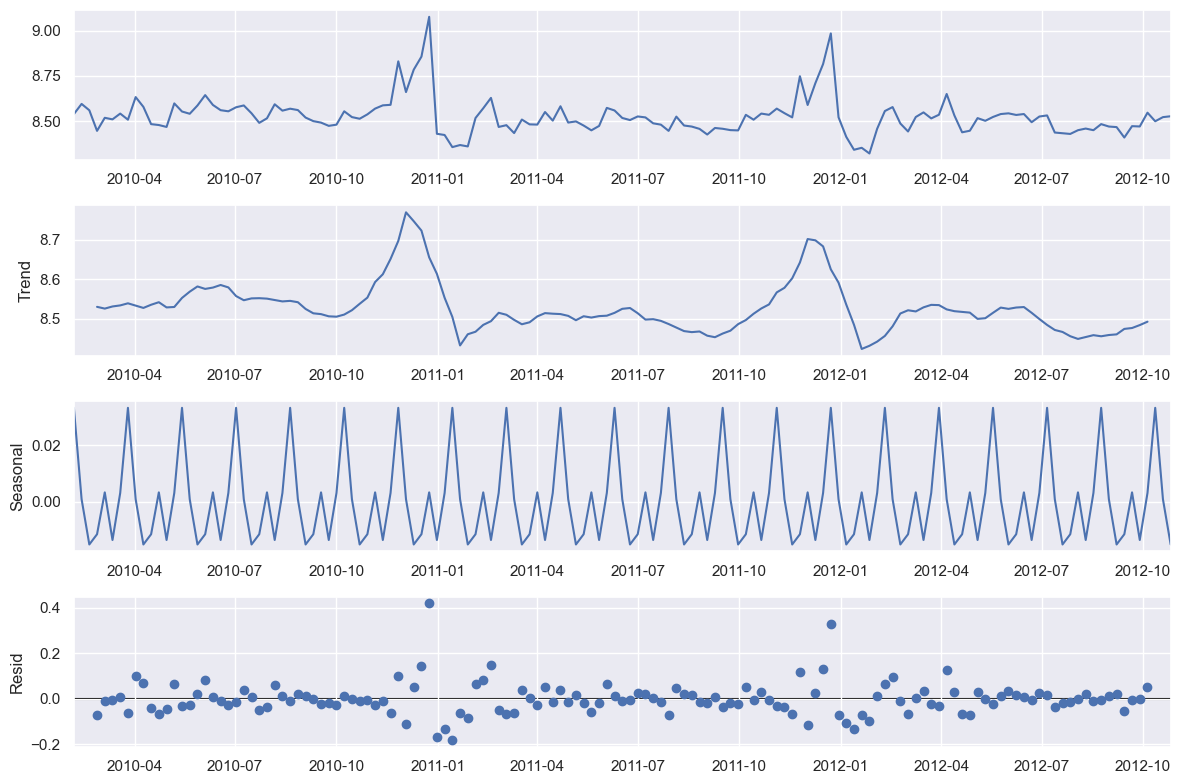

In [178]:
# from statsmodels.tsa.seasonal import seasonal_decompose
#
# # Decompose the time series
# decomposition = seasonal_decompose(df_date[target_column], model='additive', period=7)
# fig = decomposition.plot()
# fig.set_size_inches(12, 8)
# plt.tight_layout()
# plt.show()

In [180]:
decomposition.seasonal


Date
2010-02-05    0.033349
2010-02-12    0.000833
2010-02-19   -0.015262
2010-02-26   -0.011616
2010-03-05    0.003279
                ...   
2012-09-28   -0.013661
2012-10-05    0.003078
2012-10-12    0.033349
2012-10-19    0.000833
2012-10-26   -0.015262
Name: seasonal, Length: 143, dtype: float64

In [111]:
# df[[f'weekdayroll4_{c}' for c in agg_feats]] = \
#     df.groupby('weekday')[agg_feats].shift().rolling(window=4).mean()

In [112]:
df[[f'month_roll1_{c}' for c in agg_feats]] = \
    df.groupby(['month'] + join_columns)[agg_feats].shift().rolling(window=1).mean()

In [114]:
df[df['month'] == '04']

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,...,lag3_rolling10_Fuel_Price,lag3_rolling10_Temperature,month,weekday,weekdayroll4_Weekly_Sales_log,weekdayroll4_Fuel_Price,weekdayroll4_Temperature,month_roll1_Weekly_Sales_log,month_roll1_Fuel_Price,month_roll1_Temperature
108624,12,6,2010-04-02,7223.39,0,B,112238,59.84,3.086,126.603484,...,2.912333,51.370000,04,4,7.845868,2.79300,48.7500,NaN,NaN,NaN
297412,31,28,2010-04-02,765.64,0,A,203750,64.12,2.719,210.479887,...,2.617667,50.340000,04,4,8.400434,2.85100,52.2500,NaN,NaN,NaN
108052,12,2,2010-04-02,69967.79,0,B,112238,59.84,3.086,126.603484,...,2.912333,51.370000,04,4,8.118910,2.81725,56.8200,NaN,NaN,NaN
256155,26,95,2010-04-02,64940.84,0,A,152513,36.53,2.826,131.901968,...,2.774667,29.006667,04,4,9.012162,2.90575,58.8650,NaN,NaN,NaN
179749,19,21,2010-04-02,10417.51,0,A,203819,45.26,2.957,131.901968,...,2.922333,34.103333,04,4,9.441072,2.92925,55.0825,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128010,13,98,2012-04-27,13614.46,0,A,219622,64.80,3.842,131.126667,...,3.732667,49.960000,04,4,9.213652,3.92950,61.2300,9.463555,3.845,50.24
181859,19,35,2012-04-27,3973.81,0,A,203819,42.45,4.163,137.978133,...,4.098333,46.806667,04,4,8.907670,3.93650,59.5550,8.303458,4.170,55.20
380766,40,97,2012-04-27,13125.30,0,A,155083,47.51,4.023,137.978133,...,3.922333,41.686667,04,4,9.093294,3.93650,59.5550,9.569675,4.046,55.30
381231,41,2,2012-04-27,47673.83,0,A,196321,57.66,3.927,197.664546,...,3.756000,48.026667,04,4,9.362088,3.96050,55.9925,10.749253,3.936,43.57


In [105]:
df['month'].unique()

<PeriodArray>
['2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08',
 '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03',
 '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10',
 '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
 '2012-06', '2012-07', '2012-08', '2012-09', '2012-10']
Length: 33, dtype: period[M]

In [109]:
df['month'].apply(lambda x: str(x)[5:])

0         02
277665    02
277808    02
277951    02
278094    02
          ..
379648    10
181170    10
181313    10
181599    10
421569    10
Name: month, Length: 420285, dtype: object

In [13]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221
421566,45,98,2012-10-05,628.10,False,B,118221
421567,45,98,2012-10-12,1061.02,False,B,118221
421568,45,98,2012-10-19,760.01,False,B,118221
